In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
### Обратное преобразование Бокса-Кокса

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
### Считываем данные
data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [4]:
data.columns = ['sallary']

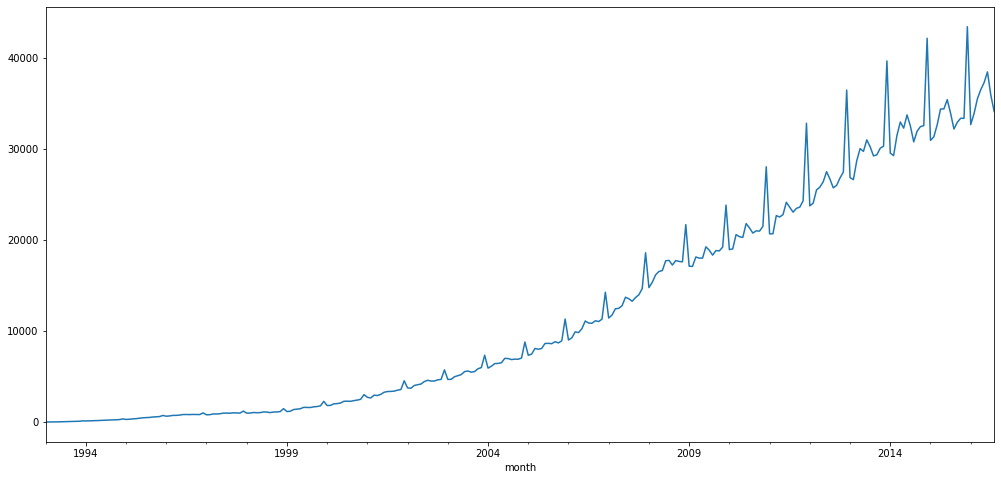

In [5]:
plt.figure(figsize = (17, 8))
data.sallary.plot()
plt.ylabel('sallary')

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

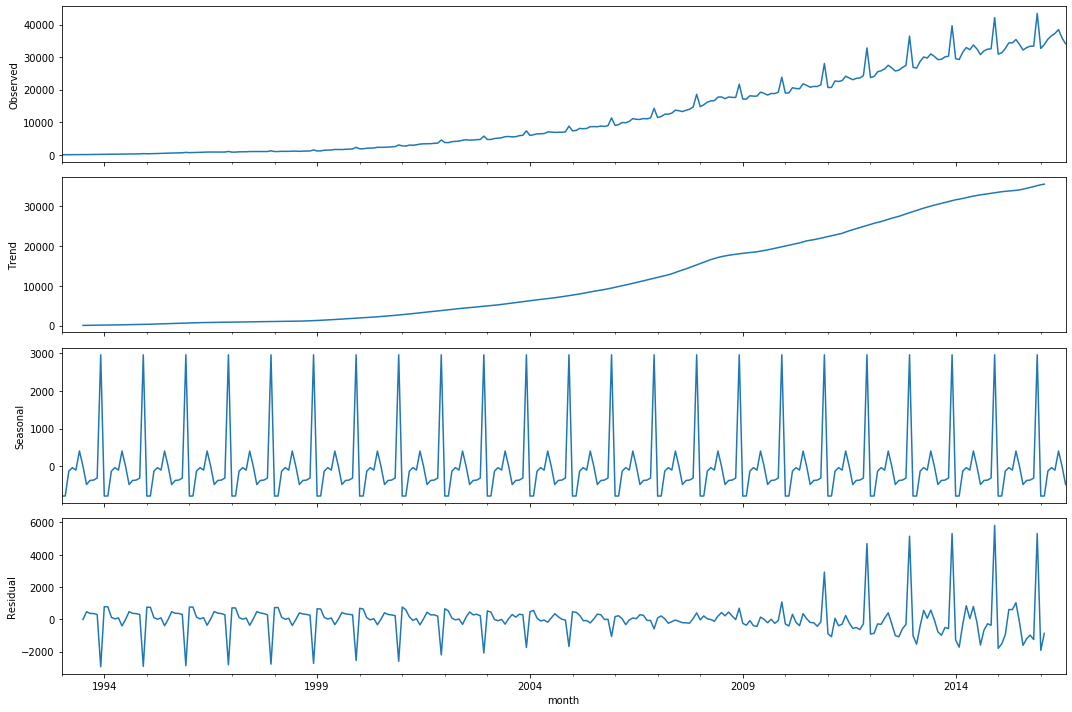

In [6]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.sallary).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.sallary)[1])

Виден повышающися тренд, годовая сезонность. Критерием Дики-Фуллера принимается 0-вая гипотеза о том, что ряд нестационарен

### Стабилизация дисперсии

In [7]:
### Выполним преобразование Бокса-Кокса

data['sallary_box'], lmbda  = stats.boxcox(data.sallary)

In [8]:
data.head()

,sallary,sallary_box
month,,
1993-01-01,15.3,3.990393
1993-02-01,19.1,4.458758
1993-03-01,23.6,4.931635
1993-04-01,30.6,5.549430
1993-05-01,37.5,6.063406


Text(0, 0.5, 'Transformed with Box-Cox sallary')

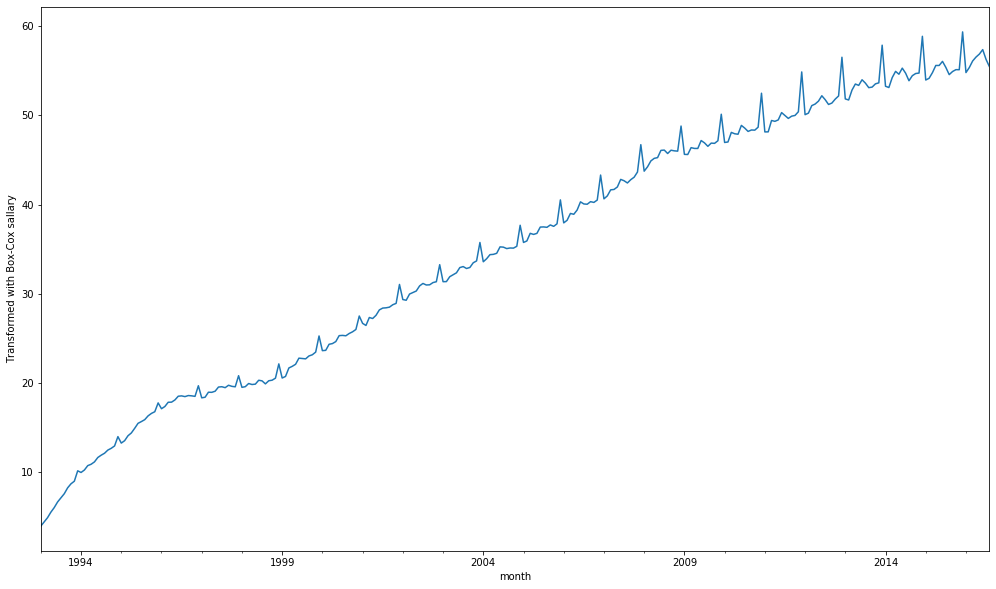

In [9]:
plt.figure(figsize = (17, 10))
data.sallary_box.plot()
plt.ylabel('Transformed with Box-Cox sallary')

In [10]:
### Посмотрим на изменение критерия Дики-Фуллера

print("Критреий Дики-Фуллера после преобразования Бокса-Кокса: {}".format(sm.tsa.adfuller(data.sallary_box)[1]) )

Критреий Дики-Фуллера после преобразования Бокса-Кокса: 0.6968987634832662


### Стационарность

Т.к. ряд все еще нестационарен, выполоним сезонное дифференцирование

In [11]:
data['sallary_box_diff'] = data.sallary_box - data.sallary_box.shift(12)

Критерий Дики-Фуллера: p=0.014697


<Figure size 1224x720 with 0 Axes>

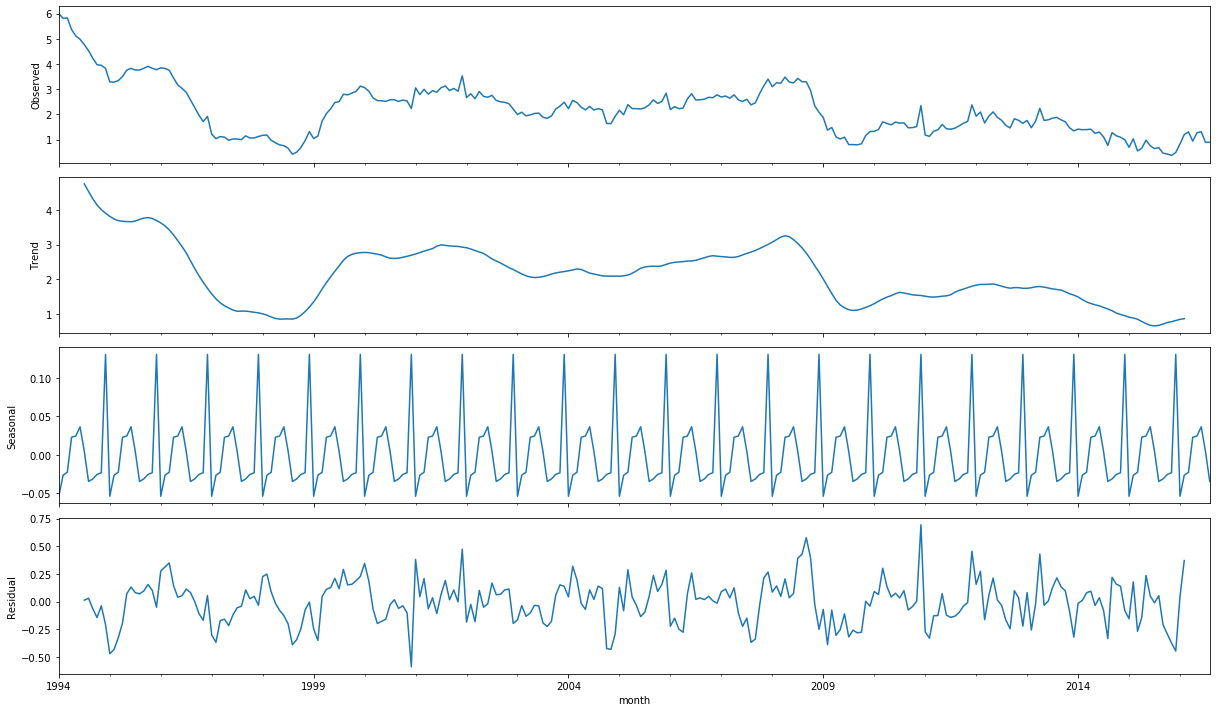

In [12]:
plt.figure(figsize(17, 10))
fig = sm.tsa.seasonal_decompose(data.sallary_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.sallary_box_diff[12:])[1])

Критерием Дики-Фулера можно отвергнуть гипотезу о нестационарности, но можно избавиться от тренда

In [13]:
data['sallary_box_diff2'] = data.sallary_box_diff - data.sallary_box_diff.shift(1)

Критерий Дики-Фуллера: p=0.000000


<Figure size 1224x720 with 0 Axes>

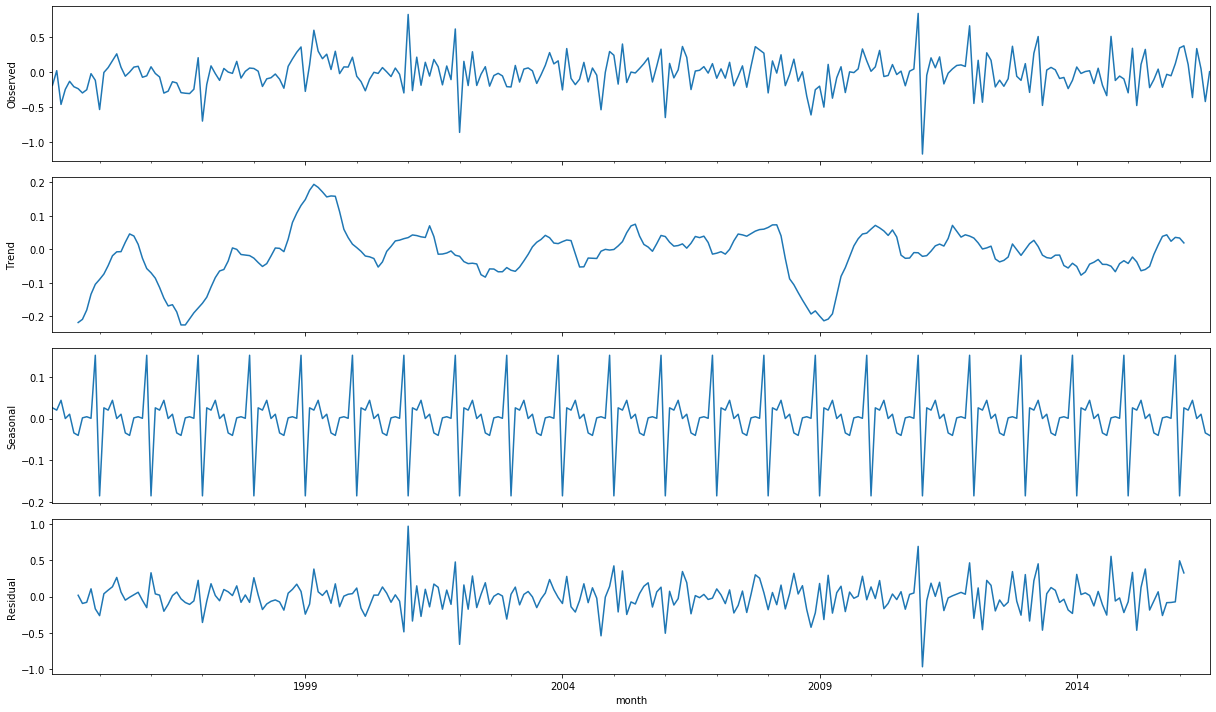

In [14]:
plt.figure(figsize(17, 10))
fig = sm.tsa.seasonal_decompose(data.sallary_box_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.sallary_box_diff2[13:])[1])

Гипотеза о нестационарности уверенно отвергается, также мы избавились от тренда

### Подбор модели

Посмотрим на ACF и PACF полученного ряда

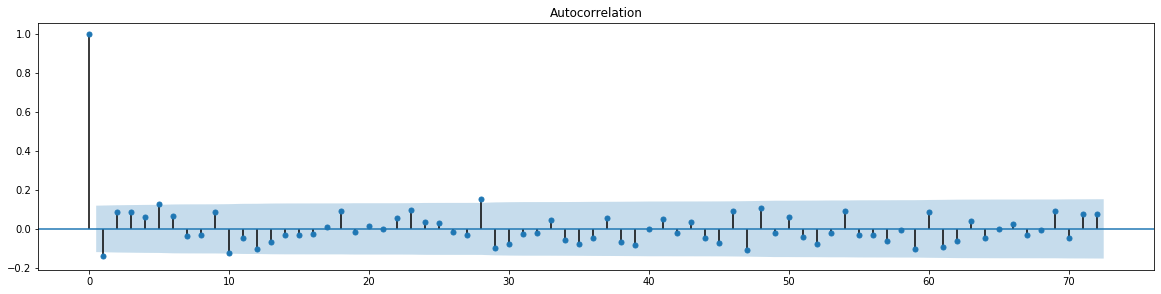

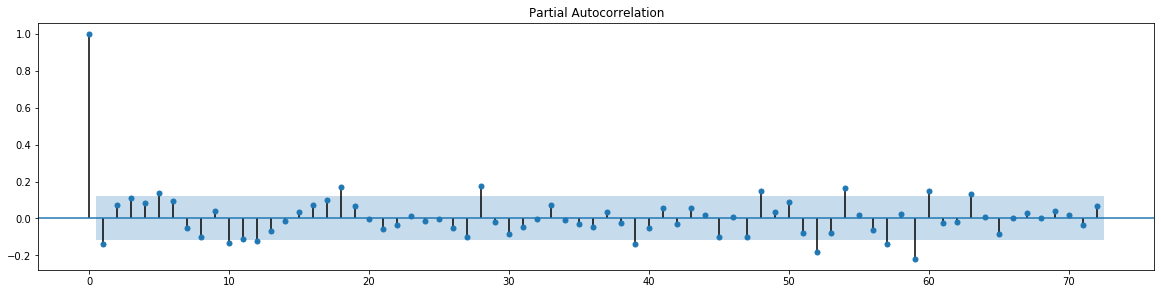

In [16]:
plt.figure(figsize(20,10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.sallary_box_diff2[13:].values.squeeze(), lags=72, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.sallary_box_diff2[13:].values.squeeze(), lags=72, ax=ax)
pylab.show()

Начальные приближения: Q = 0, q = 10, P = 5, p = 10

In [17]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 6)
D=1
Qs = range(0, 1)

In [18]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

216

Из-за ошибки в разложении матрицы, при некоторых параметрах выбрасывает LinAlgError, у меня считалось ~ 30 минут все.
<t>
    
Возможно стоить поставить таймер на max_time одной итерации и выбрасывать исключение

In [19]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.sallary_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except np.linalg.LinAlgError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

(0, 0, 0, 0)
yep
(0, 0, 1, 0)
yep
(0, 0, 2, 0)
yep
(0, 0, 3, 0)
yep
(0, 0, 4, 0)
yep
(0, 0, 5, 0)
yep
(0, 1, 0, 0)
yep
(0, 1, 1, 0)
yep
(0, 1, 2, 0)
yep
(0, 1, 3, 0)
yep
(0, 1, 4, 0)
yep
(0, 1, 5, 0)
yep
(0, 2, 0, 0)
yep
(0, 2, 1, 0)
yep
(0, 2, 2, 0)
yep
(0, 2, 3, 0)
yep
(0, 2, 4, 0)
yep
(0, 2, 5, 0)
yep
(0, 3, 0, 0)
yep
(0, 3, 1, 0)
yep
(0, 3, 2, 0)
yep
(0, 3, 3, 0)
yep
(0, 3, 4, 0)
yep
(0, 3, 5, 0)
yep
(0, 4, 0, 0)
yep
(0, 4, 1, 0)
yep
(0, 4, 2, 0)
yep
(0, 4, 3, 0)
yep
(0, 4, 4, 0)
yep
(0, 4, 5, 0)
yep
(0, 5, 0, 0)
yep
(0, 5, 1, 0)
yep
(0, 5, 2, 0)
yep
(0, 5, 3, 0)
yep
(0, 5, 4, 0)
yep
(0, 5, 5, 0)
yep
(1, 0, 0, 0)
yep
(1, 0, 1, 0)
yep
(1, 0, 2, 0)
yep
(1, 0, 3, 0)
yep
(1, 0, 4, 0)
yep
(1, 0, 5, 0)
yep
(1, 1, 0, 0)
yep
(1, 1, 1, 0)
yep
(1, 1, 2, 0)
yep
(1, 1, 3, 0)
yep
(1, 1, 4, 0)
yep
(1, 1, 5, 0)
yep
(1, 2, 0, 0)
yep
(1, 2, 1, 0)
yep
(1, 2, 2, 0)
yep
(1, 2, 3, 0)
yep
(1, 2, 4, 0)
yep
(1, 2, 5, 0)
yep
(1, 3, 0, 0)
yep
(1, 3, 1, 0)
yep
(1, 3, 2, 0)
yep
(1, 3, 3, 0)
yep
(1, 3, 4, 0)
y

In [20]:
best_aic

-25.09042979201309

In [22]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        sallary_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.545
Date:                            Fri, 14 Aug 2020   AIC                            -25.090
Time:                                    15:27:07   BIC                             18.135
Sample:                                01-01-1993   HQIC                            -7.735
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2200      0.594     -0.371      0.711      -1.384       0.944
ar.L2          0.2427      0.418   

### Посмотрим на остатки лучшей модели:

Критерий Стьюдента: p=0.162261
Критерий Дики-Фуллера: p=0.000000


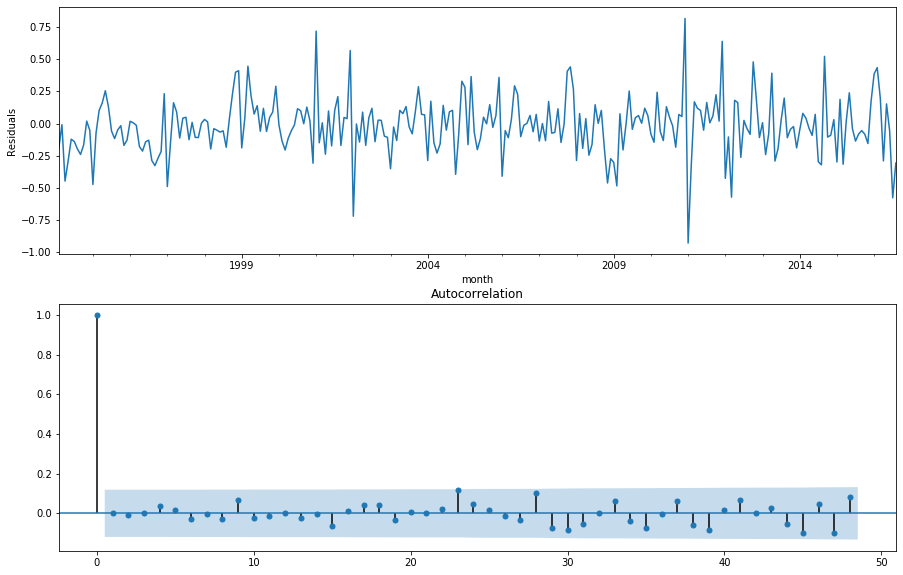

In [25]:
plt.figure(figsize(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены, что подтверждается критерием Стьюдента.
<t>
    
Также гипотеза о нестационарности остатков уверенно отвергается критерием Дики-Фулера

### Сравнение исторических данных и модельных

Text(0, 0.5, 'Mean sallary')

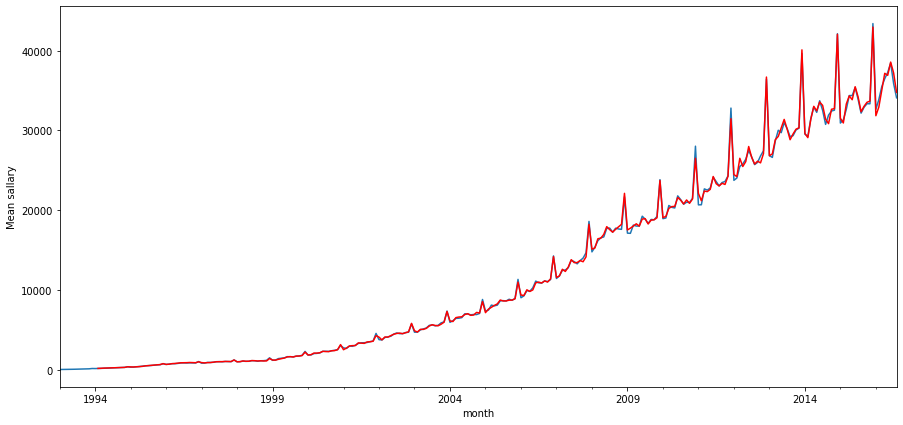

In [27]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.sallary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Mean sallary')

### Прогноз модели

Text(0, 0.5, ' Mean sallary')

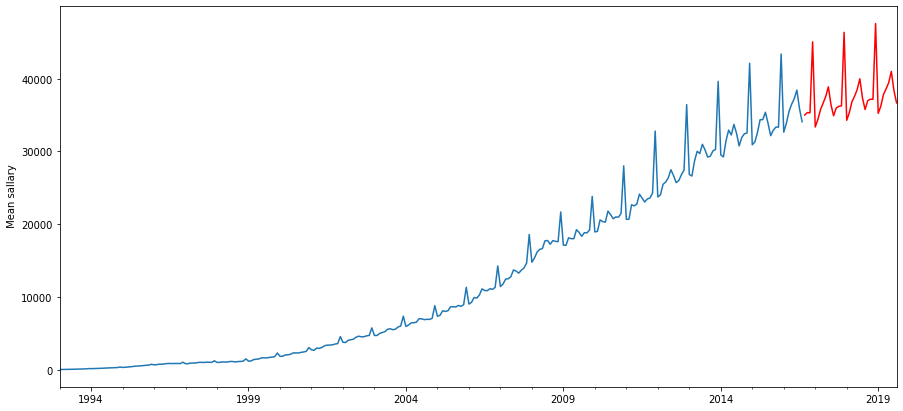

In [52]:
sallary2 = data[['sallary']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= sallary2.columns)
sallary2 = pd.concat([sallary2, future])
sallary2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
sallary2.sallary.plot()
sallary2.forecast.plot(color='r')
plt.ylabel(' Mean sallary')